# Writting Efficient Queries

Sometimes it doesn't matter whether your query is efficient or not. For example, you might write a query you expect to run only once, and it might be working on a small dataset. In this case, anything that gives you the answer you need will do.

But what about queries that will be run many times, like a query that feeds data to a website? Those need to be efficient so you don't leave users waiting for your website to load.

Or what about queries on huge datasets? These can be slow and cost a business a lot of money if they are written poorly.

Most database systems have a query optimizer that attempts to interpret/execute your query in the most effective way possible. But several strategies can still yield huge savings in many cases.

## Some useful functions
We will use two functions to compare the efficiency of different queries:

- show_amount_of_data_scanned() shows the amount of data the query uses.
- show_time_to_run() prints how long it takes for the query to execute.

## Strategies
### 1) Only select the columns you want.
It is tempting to start queries with SELECT * FROM .... It's convenient because you don't need to think about which columns you need. But it can be very inefficient.

This is especially important if there are text fields that you don't need, because text fields tend to be larger than other fields.


In [1]:
from google.cloud import bigquery
from time import time

client = bigquery.Client(project="sqlbigquery7711")

def show_amount_of_data_scanned(query):
    # dry_run lets us see how much data the query uses without running it
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)
    query_job = client.query(query, job_config=dry_run_config)
    print('Data processed: {} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))
    
def show_time_to_run(query):
    time_config = bigquery.QueryJobConfig(use_query_cache=False)
    start = time()
    query_result = client.query(query, job_config=time_config).result()
    end = time()
    print('Time to run: {} seconds'.format(round(end-start, 3)))

star_query = "SELECT * FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(star_query)

basic_query = "SELECT size, binary FROM `bigquery-public-data.github_repos.contents`"
show_amount_of_data_scanned(basic_query)

Data processed: 2682.118 GB
Data processed: 2.531 GB


### 2) Read less data.
Both queries below calculate the average duration (in seconds) of one-way bike trips in the city of San Francisco.

In [2]:
more_data_query = """
                  SELECT MIN(start_station_name) AS start_station_name,
                      MIN(end_station_name) AS end_station_name,
                      AVG(duration_sec) AS avg_duration_sec
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_id != end_station_id 
                  GROUP BY start_station_id, end_station_id
                  LIMIT 10
                  """
show_amount_of_data_scanned(more_data_query)

less_data_query = """
                  SELECT start_station_name,
                      end_station_name,
                      AVG(duration_sec) AS avg_duration_sec                  
                  FROM `bigquery-public-data.san_francisco.bikeshare_trips`
                  WHERE start_station_name != end_station_name
                  GROUP BY start_station_name, end_station_name
                  LIMIT 10
                  """
show_amount_of_data_scanned(less_data_query)

Data processed: 0.076 GB
Data processed: 0.06 GB


### 3) Avoid N:N JOINs.
Most of the JOINs that you have executed in this course have been 1:1 JOINs. In this case, each row in each table has at most one match in the other table.
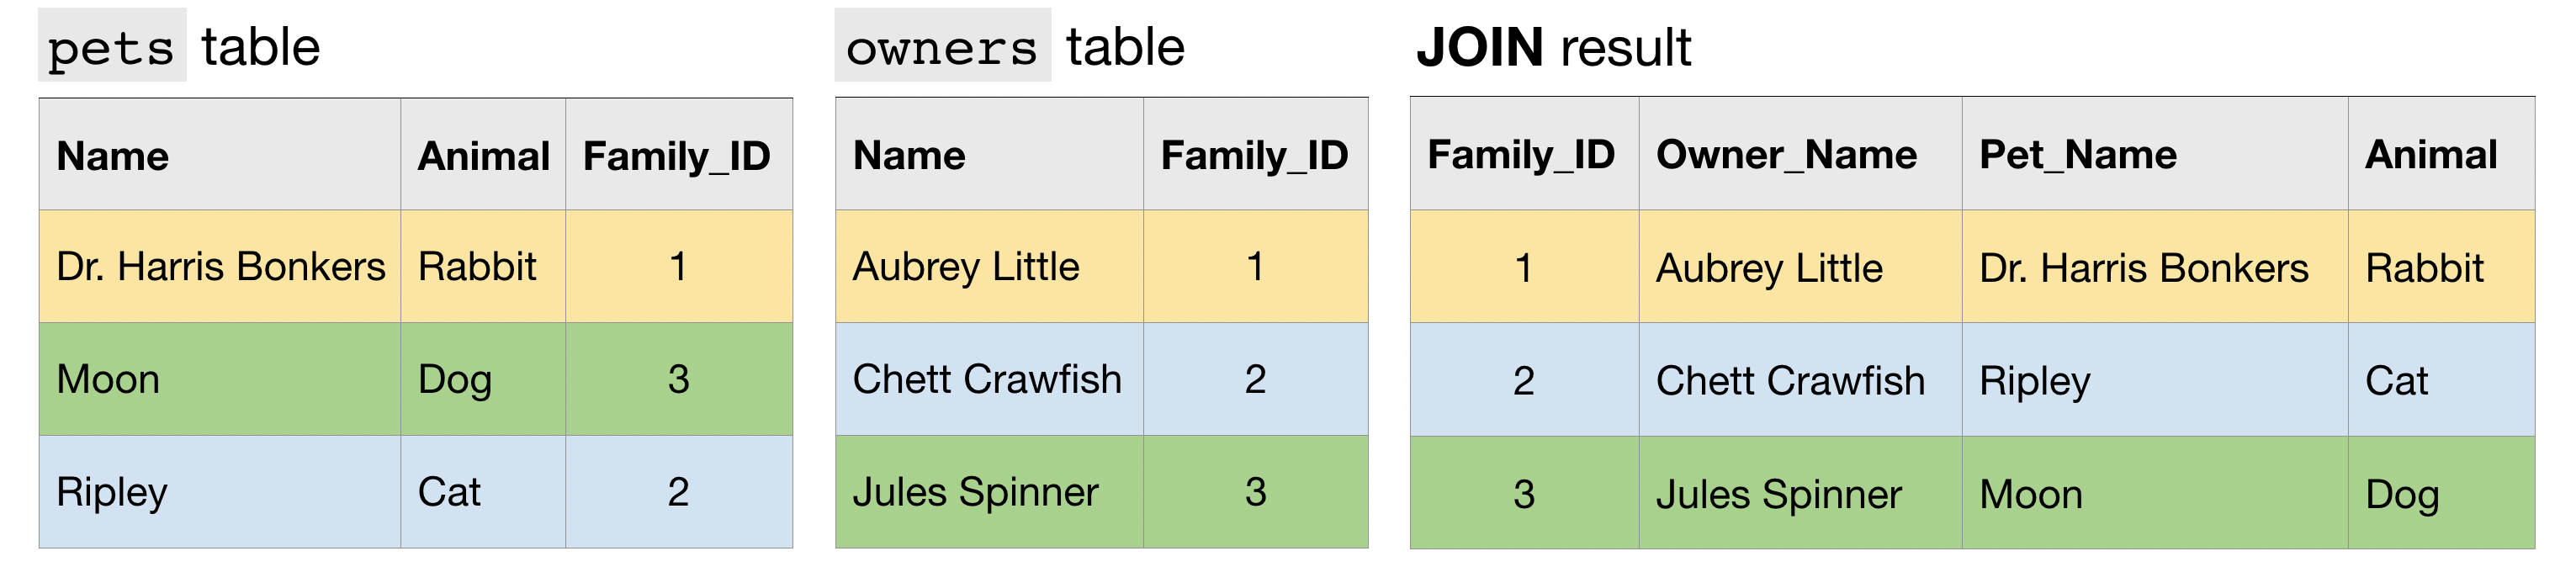
Another type of JOIN is an N:1 JOIN. Here, each row in one table matches potentially many rows in the other table.
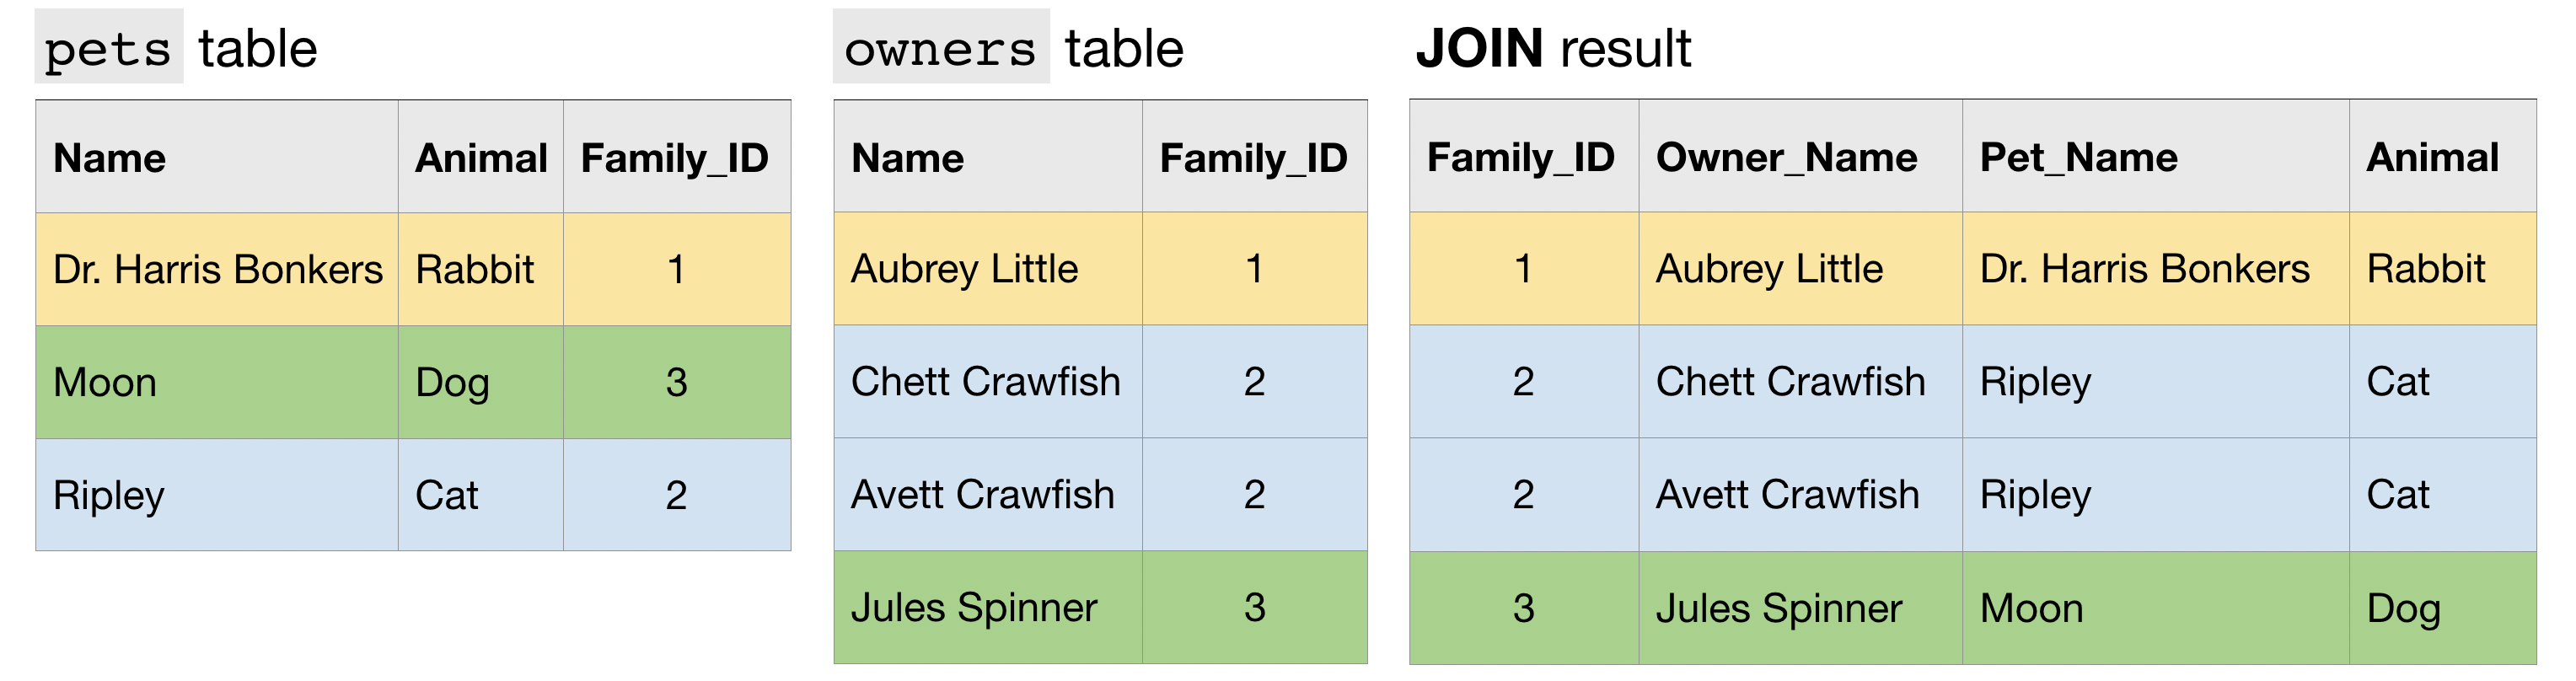

Finally, an N:N JOIN is one where a group of rows in one table can match a group of rows in the other table. Note that in general, all other things equal, this type of JOIN produces a table with many more rows than either of the two (original) tables that are being JOINed.
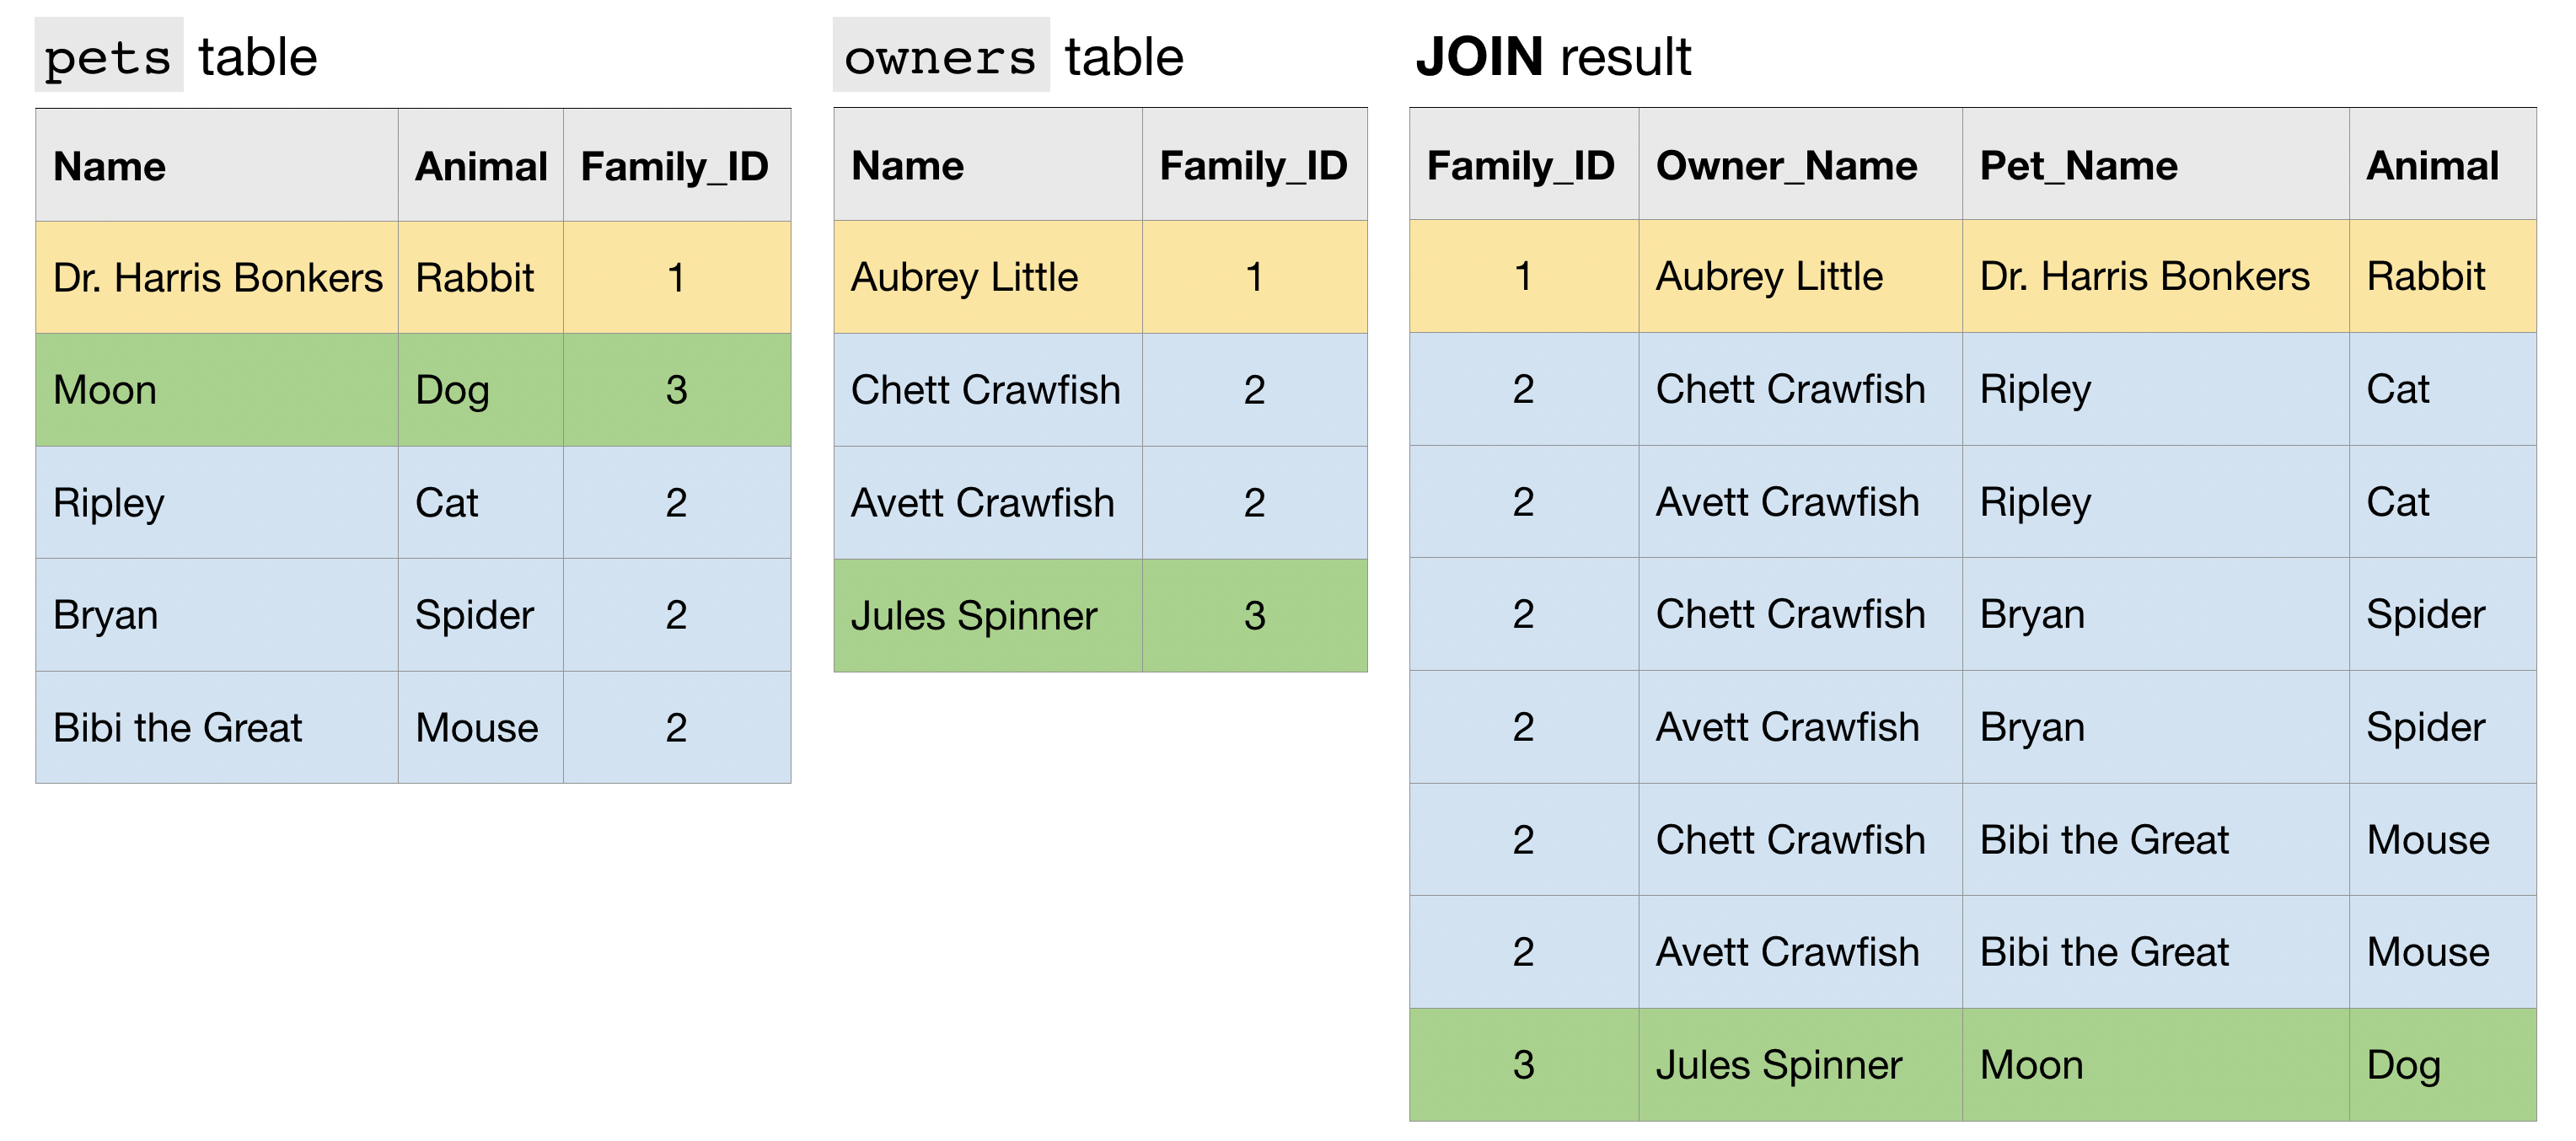


In [3]:
big_join_query = """
                 SELECT repo,
                     COUNT(DISTINCT c.committer.name) as num_committers,
                     COUNT(DISTINCT f.id) AS num_files
                 FROM `bigquery-public-data.github_repos.commits` AS c,
                     UNNEST(c.repo_name) AS repo
                 INNER JOIN `bigquery-public-data.github_repos.files` AS f
                     ON f.repo_name = repo
                 WHERE f.repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                 GROUP BY repo
                 ORDER BY repo
                 """
show_time_to_run(big_join_query)

small_join_query = """
                   WITH commits AS
                   (
                   SELECT COUNT(DISTINCT committer.name) AS num_committers, repo
                   FROM `bigquery-public-data.github_repos.commits`,
                       UNNEST(repo_name) as repo
                   WHERE repo IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   ),
                   files AS 
                   (
                   SELECT COUNT(DISTINCT id) AS num_files, repo_name as repo
                   FROM `bigquery-public-data.github_repos.files`
                   WHERE repo_name IN ( 'tensorflow/tensorflow', 'facebook/react', 'twbs/bootstrap', 'apple/swift', 'Microsoft/vscode', 'torvalds/linux')
                   GROUP BY repo
                   )
                   SELECT commits.repo, commits.num_committers, files.num_files
                   FROM commits 
                   INNER JOIN files
                       ON commits.repo = files.repo
                   ORDER BY repo
                   """

show_time_to_run(small_join_query)

Time to run: 19.406 seconds
Time to run: 3.388 seconds


## Exercises

You have the following two tables:

![](https://storage.googleapis.com/kaggle-media/learn/images/E9jikOQ.png)

The `CostumeLocations` table shows timestamped GPS data for all of the pet costumes in the database, where `CostumeID` is a unique identifier for each costume.  

The `CostumeOwners` table shows who owns each costume, where the `OwnerID` column contains unique identifiers for each (human) owner.  Note that each owner can have more than one costume!  And, each costume can have more than one owner: this allows multiple individuals from the same household (all with their own, unique `OwnerID`) to access the locations of their pets' costumes.

Say you need to use these tables to get the current location of one pet in particular: Mitzie the Dog recently ran off chasing a squirrel, but thankfully she was last seen in her hot dog costume!

One of Mitzie's owners (with owner ID `MitzieOwnerID`) logs into your website to pull the last locations of every costume in his possession.  Currently, you get this information by running the following query:

```sql
WITH LocationsAndOwners AS 
(
SELECT * 
FROM CostumeOwners co INNER JOIN CostumeLocations cl
   ON co.CostumeID = cl.CostumeID
),
LastSeen AS
(
SELECT CostumeID, MAX(Timestamp)
FROM LocationsAndOwners
GROUP BY CostumeID
)
SELECT lo.CostumeID, Location 
FROM LocationsAndOwners lo INNER JOIN LastSeen ls 
	ON lo.Timestamp = ls.Timestamp AND lo.CostumeID = ls.CostumeID
WHERE OwnerID = MitzieOwnerID
```


Is there a way to make this faster or cheaper?

YES!

```sql
WITH CurrentOwnersCostumes AS
(
SELECT CostumeID 
FROM CostumeOwners 
WHERE OwnerID = MitzieOwnerID
),
OwnersCostumesLocations AS
(
SELECT cc.CostumeID, Timestamp, Location 
FROM CurrentOwnersCostumes cc INNER JOIN CostumeLocations cl
    ON cc.CostumeID = cl.CostumeID
),
LastSeen AS
(
SELECT CostumeID, MAX(Timestamp)
FROM OwnersCostumesLocations
GROUP BY CostumeID
)
SELECT ocl.CostumeID, Location 
FROM OwnersCostumesLocations ocl INNER JOIN LastSeen ls 
    ON ocl.timestamp = ls.timestamp AND ocl.CostumeID = ls.costumeID
```    
Why is this better?

Instead of doing large merges and running calculations (like finding the last timestamp) for every costume, we discard the rows for other owners as the first step. So each subsequent step (like calculating the last timestamp) is working with something like 99.999% fewer rows than what was needed in the original query.

Databases have something called “Query Planners” to optimize details of how a query executes even after you write it. Perhaps some query planner would figure out the ability to do this. But the original query as written would be very inefficient on large datasets